#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

#Download the Dataset

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

#Load and Preprocess the Dataset

In [ ]:
def normalize(input_image, input_mask):
  img = tf.cast(input_image, dtype=tf.float32) / 255.0
  input_mask -= 1
  return img, input_mask

In [ ]:
@tf.function
def load_train_ds(dataset):
  img = tf.image.resize(dataset['image'], size=(width, height))
  mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))

  if tf.random.uniform(()) > 0.5:
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)

  img, mask = normalize(img, mask)
  return img, mask

In [ ]:
@tf.function
def load_test_ds(dataset):
  img = tf.image.resize(dataset['image'], size=(width, height))
  mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))

  img, mask = normalize(img, mask)
  return img, mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

width, height = 224, 224

In [ ]:
train = dataset['train'].map(load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_test_ds)

In [ ]:
train, test

(<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>)

In [ ]:
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>)

#Visualize Image

In [ ]:
def display_images(display_list):
  plt.figure(figsize = (15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')

  plt.show()

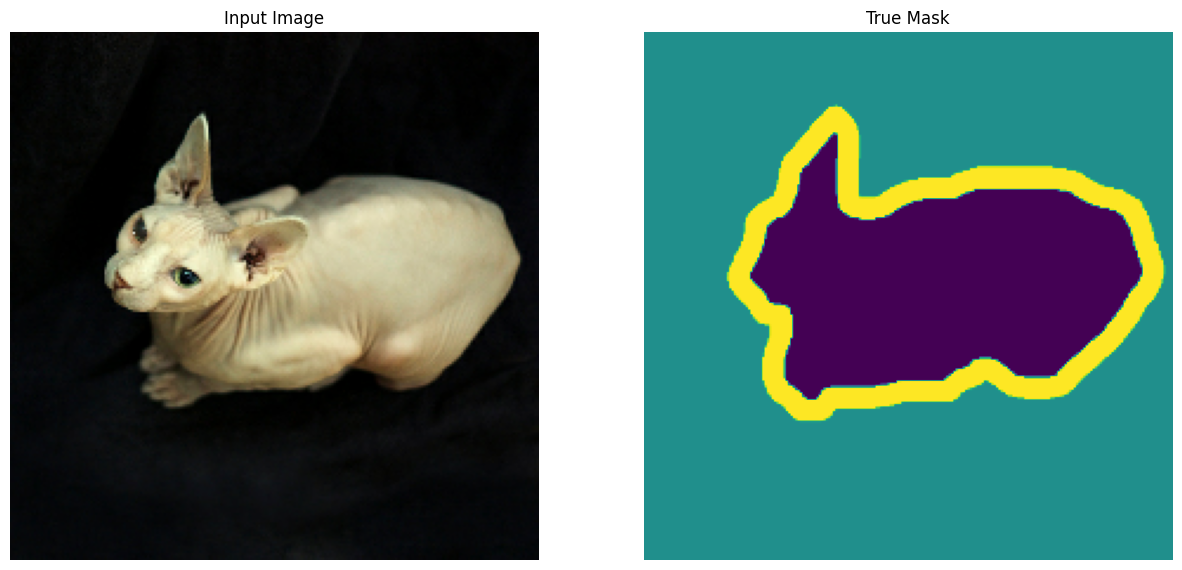

In [ ]:
for img, mask in train.take(1):
  sample_image, sample_mask = img, mask
  display_list = sample_image, sample_mask

display_images(display_list)

#Define Model

#####VGG-16 Encoder

In [ ]:
base_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(width, height, 3))

layer_names = [
               'block1_pool',
               'block2_pool',
               'block3_pool',
               'block4_pool',
               'block5_pool',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

#####Fully-Convolutional-Network-8 Decoder

In [ ]:
def fcn8_decoder(convs, n_classes):
  f1, f2, f3, f4, p5 = convs

  n = 4096
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  f5 = c7

   # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = tf.keras.layers.Activation('softmax')(o)
  return o

#####Final Model

In [ ]:
def segmentation_model():

  inputs = keras.layers.Input(shape = (width, height, 3))
  convs = VGG_16(inputs)
  outputs = fcn8_decoder(convs, 3)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

#####Compile Model

In [ ]:
# opt = keras.optimizers.SGD(momentum=0.9)
opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

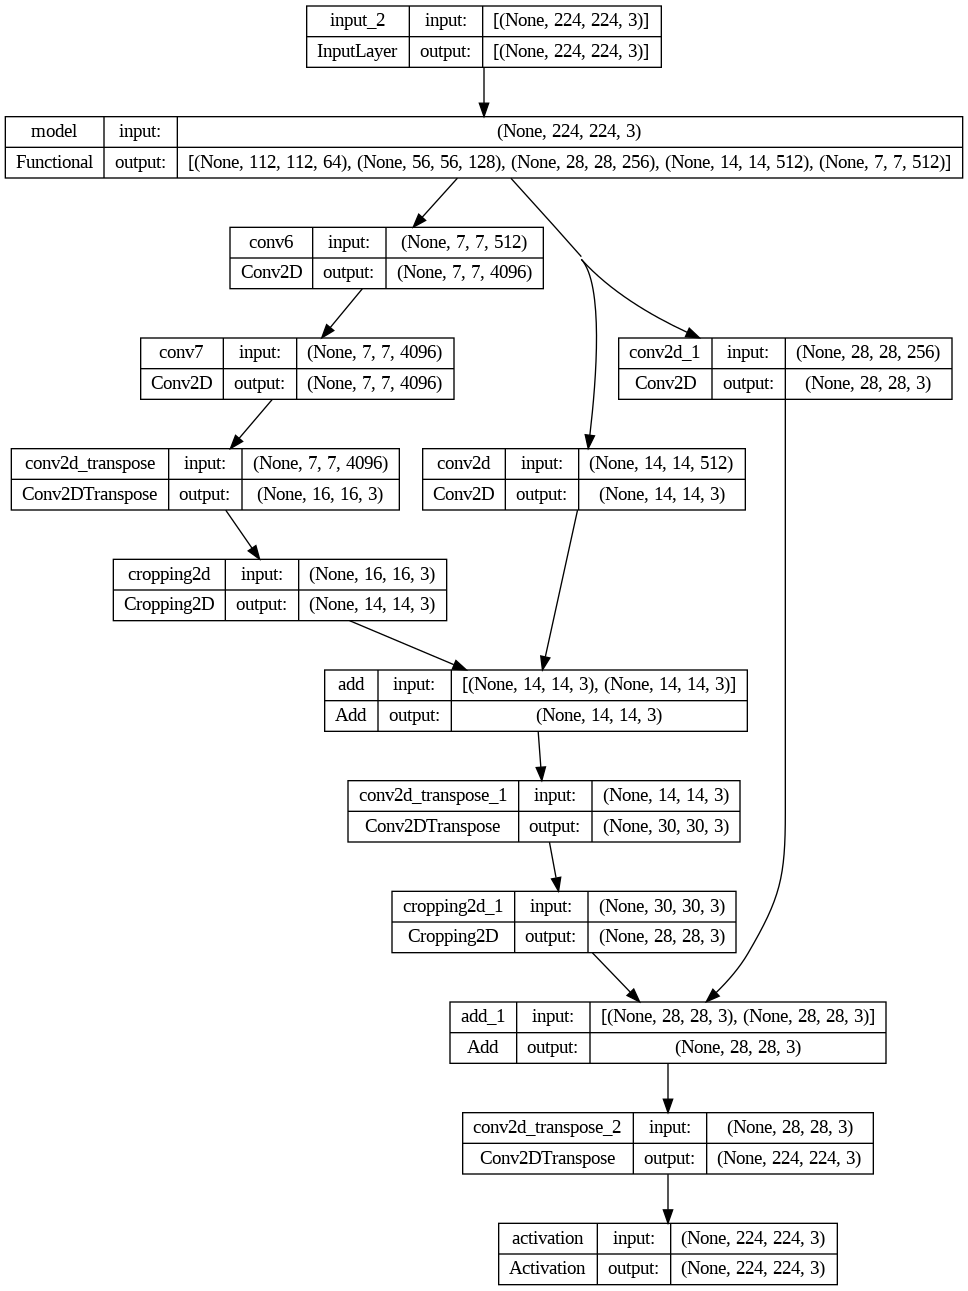

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

#####Creating Mask for predicted image & Visualization utilities

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display_images([image[0], mask[0], create_mask(pred_mask)])
  else:
    display_images([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


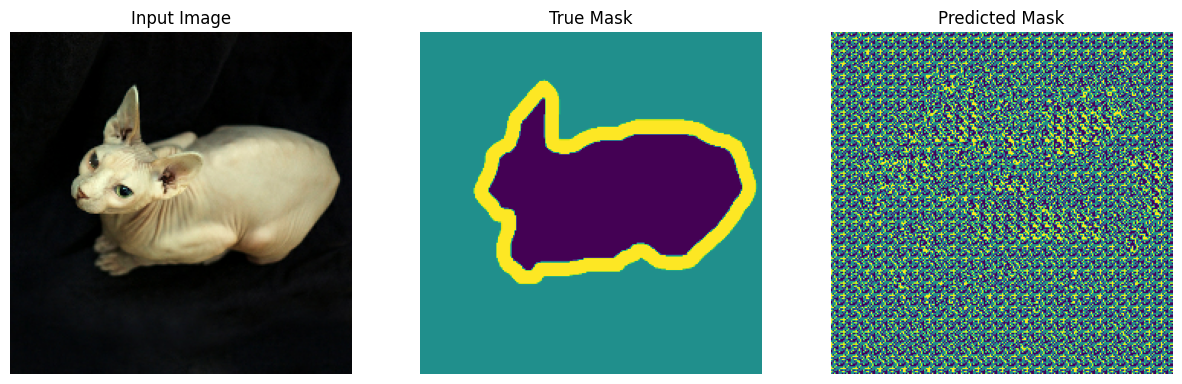

In [ ]:
show_predictions()

#####Custom Callbacks & training Model

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 19ms/step


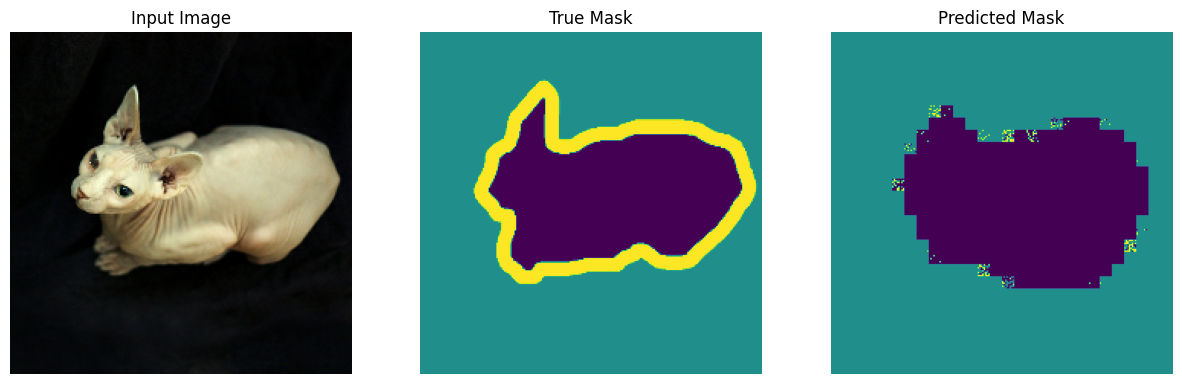


Sample Prediction after epoch 5

57/57 [==============================] - 46s 810ms/step - loss: 0.3312 - accuracy: 0.8487 - val_loss: 0.4221 - val_accuracy: 0.8251


In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])

In [ ]:
#model.save_weights('/content/Checkpoints/model_checkpoints')
# model.load_weights('/content/Checkpoints/model_checkpoints')

#Compute Metrics
$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$

$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

In [ ]:

def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''

  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(3):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

#Evaluate Model

In [ ]:
def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_ds.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  images = images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images, y_true_segments

In [ ]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
results = model.predict(test_ds, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]
results.shape

#####Display Class Wise Metrics

In [ ]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)
cls_wise_iou, cls_wise_dice_score

In [ ]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']

# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}: {} ".format(class_names[idx], spaces, iou))

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}: {} ".format(class_names[idx], spaces, dice_score))

In [ ]:
y_true_images.shape

#Show Predictions and Metrics

In [ ]:
integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))
y_pred_mask = model.predict(img)
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape

In [ ]:
def display_prediction(display_list, display_string):
  plt.figure(figsize = (15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.xticks([])
    plt.yticks([])
    if i == 1:
      plt.xlabel(display_string, fontsize = 12)
    plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
    # plt.axis('off')
  # plt.xlabel(display_string, fontsize = 14)
  plt.show()

In [ ]:
iou, dice_score = compute_metrics(y_true_segments[integer_slider], y_pred_mask.numpy())
display_list = [y_true_images[integer_slider], y_true_segments[integer_slider], y_pred_mask]

display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], i, dc) for idx, (i, dc) in
                       enumerate(zip(np.round(iou, 4), np.round(dice_score, 4)))]
display_string = "\n\n".join(display_string_list)


# showing predictions with metrics
display_prediction(display_list, display_string)